**Data 612: Project 3 - Matrix Factorization Methods<br>Christina Valore, Juliann McEachern, & Rajwant Mishra<br>Due: June 25, 2019**

<h1 align="center">Goodreads Recommender Systems</h1>

<h2 style="color:#088A68;">Getting Started</h2>

For project 3, we choose to continue our work with Goodreads books and build a recommender system that utilizes implicit matrix factorization techniques. As we have learned, singular value decomposition (SVD) matrices can be computationally expensive. Thus, our work will focus on a small subset of Goodreads book data that we previously explored in [Project 2](https://nbviewer.jupyter.org/github/jemceach/612-group/blob/master/project-2/report.ipynb). 

We will also compare the performance of our functions and calculations to the results generated by the `surprise` package. 

#### Python Dependencies

In [1]:
# The usual suspects 
import numpy as np, pandas as pd 

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Scikits packages
## Suprise!
from surprise.model_selection import train_test_split
from surprise import KNNWithMeans, SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split

## TFIDF
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer


#### Data Preparation  

Data was loaded from our Project 2 repository collection of Goodread books, ratings, and tags. Tranformations then were used to combine the datasets. 

In [2]:
# Load data into respective frames
books = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/books.csv',memory_map=True,engine='c', usecols=['goodreads_book_id','book_id', 'title', 'authors'])
ratings = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/ratings.tar.gz', 
                      compression='gzip', usecols=['user_id','book_id', 'rating'],memory_map=True,engine='c',skiprows=[5976480])
tags = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/book_tags.csv', engine='c', usecols=['goodreads_book_id','tag_id'],memory_map=True)
tag_id = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/tags.csv',memory_map=True,engine='c')

# transformations to join dataframes
book_tags = tags.set_index('tag_id').join(tag_id.set_index('tag_id')).merge(books, on='goodreads_book_id', how="inner")
data = ratings.set_index('book_id').join(books.set_index('book_id')).drop('goodreads_book_id', axis=1).reset_index()

In [3]:
# view unique data attributes
data.nunique()

book_id    10000
user_id    53424
rating         5
authors     4664
title       9964
dtype: int64

#### Content-Based Data Subset

We revisited our content-based filtering function from Project 2 to optimize our subset of 10,000 goodread's books. We used this function to narrow down 100 books related to the novel, "Pride and Prejudice".

We found that these recommendations had a very large spread in total number of unique user ratings per book. As a result, we controled this wide distribution by only looking at 25 books in the 3rd quartile of total number of ratings by user. In doing so, we eliminated 12,969 unique user ratings. We further subsetted our selection by randomly sampling 4 user ratings per book to construct our final dataframe of 100 unique user ids and 25 related books.  

In [4]:
# Reused CBF TFIDF to create best subset for analysis
CBF = book_tags.groupby(['goodreads_book_id','book_id','title','authors'],as_index=False).agg(lambda x:', '.join(x)).rename({'tag_name':'tags'}, axis=1).drop('goodreads_book_id', axis=1)
tdv = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english') # create vector
tfidf = tdv.fit_transform(CBF['tags']) # apply tfidf vector
cos = linear_kernel(tfidf, tfidf) # cosine similarity
i = pd.Series(data=CBF.index, index=CBF['title']) # index book_id for function

# Recommendation function 
def recommend(title):
    subset = CBF[['book_id','title', 'authors']] # set recommendation output
    idx = i[title] # set index to title
    #subset cos score
    score = pd.DataFrame(enumerate(cos[idx]), columns=['ID', 'score']).drop('ID', axis=1).sort_values('score', ascending = False).iloc[1:,]
    # recommend 100 books with some relation
    top_n = score[0:100]
    rec = subset.iloc[top_n.index].join(top_n).drop('score',axis=1)
    rec.index = np.arange(1, len(rec) + 1)
    return rec

recommended=recommend("Pride and Prejudice").merge(data, on=['book_id', 'title', 'authors'], how='inner')

# subset 25 books in the 3rd quartile of user ratings
book_user=pd.DataFrame(recommended.groupby(['book_id','title'])['user_id'].nunique()).reset_index()
book_user['quartile']=pd.qcut(book_user['user_id'], 4, labels=False)
book_subset = book_user[book_user['quartile']==2].drop(['title','user_id', 'quartile'],axis=1)
book_subset=book_subset.merge(recommended, on='book_id', how='inner') # merge random books on recommended selection to create subset

# subset 4 ratings by title at random to get 100 total selections
np.random.seed(seed=1) 
gp = book_subset.groupby(['book_id']) # group books
ix = np.hstack([np.random.choice(v,4, replace=False) for v in gp.groups.values()])  # select 50 ratings per book
random_book = pd.DataFrame(book_subset.iloc[ix]['user_id']) # join random index on books
subset=random_book.merge(book_subset, on='user_id', how='inner') # merge random books on recommended selection to create subset

# square-matrices
binary_matrix=subset.pivot_table(index='user_id', columns='title', values='rating', aggfunc='count', fill_value=0)
rating_matrix=subset.pivot_table(index='user_id', columns='title', values='rating', aggfunc='sum', fill_value=0)

# long-matrices
reset_m=binary_matrix.reset_index()
binary_matrix_long = pd.melt(reset_m, id_vars='user_id', value_vars=list(binary_matrix.columns[1:]), var_name='title', value_name='value')
reset_m=rating_matrix.reset_index()
rating_matrix_long = pd.melt(reset_m, id_vars='user_id', value_vars=list(rating_matrix.columns[1:]), var_name='title', value_name='value')


The chart below shows the number of user ratings per our recommended books before and after subsetting our book and user selections. 

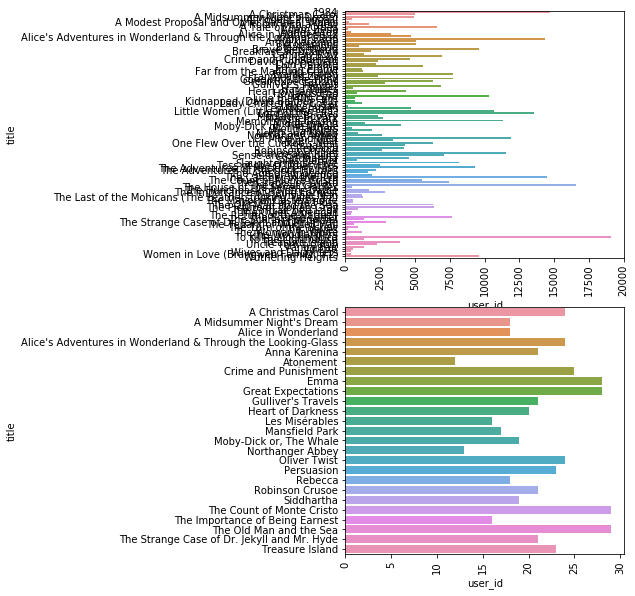

In [5]:
rating_count = pd.DataFrame(recommended.groupby(['title'])['user_id'].count()).reset_index()
rand_count = pd.DataFrame(subset.groupby(['title'])['user_id'].count()).reset_index()

fig = plt.figure(figsize=(5,10)); ax = fig.subplots(nrows=2, ncols=1)

rc1=sns.catplot(x='user_id', y="title", kind="bar",data=rating_count,ax=ax[0]); plt.close()
rc2=sns.catplot(x='user_id', y="title", kind="bar",data=rand_count,ax=ax[1]); plt.close()

for ax in fig.axes:
    plt.sca(ax); plt.xticks(rotation=90)

plt.show()

## to do: clean up plot

#### User-Item Matrix

We created two user-item matrices, that can be previewed below. The first shows a binary user-item matrix, where 1 means the user has rated the book and 0 means the book was not rated by a user. 

In [6]:
binary_matrix.head(10)

title    A Christmas Carol  A Midsummer Night's Dream  Alice in Wonderland  \
user_id                                                                      
110                      0                          0                    1   
115                      0                          0                    0   
321                      0                          1                    1   
900                      0                          0                    0   
1032                     0                          1                    0   
1478                     0                          1                    0   
2955                     0                          0                    0   
3310                     0                          0                    1   
3992                     0                          0                    0   
6289                     1                          0                    0   

title    Alice's Adventures in Wonderland & Through the Looking-Glass  \
user_id                                                                 
110                                                      0              
115                                                      0              
321                                                      0              
900                                                      0              
1032                                                     0              
1478                                                     1              
2955                                                     0              
3310                                                     0              
3992                                                     0              
6289                                                     0              

title    Anna Karenina  Atonement  Crime and Punishment  Emma  \
user_id                                                         
110                  0          0                     0     0   
115                  0          0                     0     0   
321                  1          0                     1     1   
900                  0          0                     0     1   
1032                 1          0                     1     0   
1478                 0          0                     0     0   
2955                 1          0                     1     0   
3310                 0          0                     1     0   
3992                 0          1                     0     0   
6289                 1          0                     1     0   

title    Great Expectations  Gulliver's Travels  ...  Oliver Twist  \
user_id                                          ...                 
110                       0                   0  ...             0   
115                       0                   0  ...             0   
321                       1                   0  ...             0   
900                       1                   0  ...             1   
1032                      0                   1  ...             0   
1478                      0                   0  ...             0   
2955                      0                   0  ...             0   
3310                      0                   0  ...             0   
3992                      0                   0  ...             0   
6289                      1                   0  ...             0   

title    Persuasion  Rebecca  Robinson Crusoe  Siddhartha  \
user_id                                                     
110               0        1                1           0   
115               0        0                0           0   
321               0        0                0           1   
900               1        0                0           0   
1032              1        0                0           0   
1478              0        0                0           0   
2955              0        0                0           1   
3310           

The distribution of binary user-ratings by book can be viewed below. 

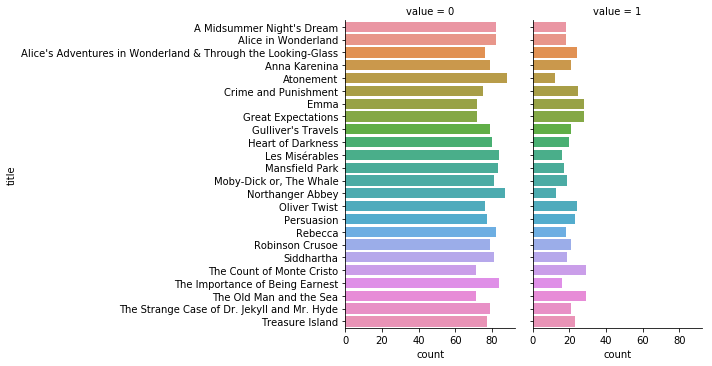

In [7]:
sns.catplot(x=None, y="title", col="value", kind="count",data=binary_matrix_long); 

Our second matrix contains the rating the book received by each user. If no rating was received, the output was coded as 0.

In [8]:
rating_matrix.head(10)

title    A Christmas Carol  A Midsummer Night's Dream  Alice in Wonderland  \
user_id                                                                      
110                      0                          0                    1   
115                      0                          0                    0   
321                      0                          4                    4   
900                      0                          0                    0   
1032                     0                          3                    0   
1478                     0                          4                    0   
2955                     0                          0                    0   
3310                     0                          0                    2   
3992                     0                          0                    0   
6289                     5                          0                    0   

title    Alice's Adventures in Wonderland & Through the Looking-Glass  \
user_id                                                                 
110                                                      0              
115                                                      0              
321                                                      0              
900                                                      0              
1032                                                     0              
1478                                                     4              
2955                                                     0              
3310                                                     0              
3992                                                     0              
6289                                                     0              

title    Anna Karenina  Atonement  Crime and Punishment  Emma  \
user_id                                                         
110                  0          0                     0     0   
115                  0          0                     0     0   
321                  4          0                     4     3   
900                  0          0                     0     3   
1032                 3          0                     4     0   
1478                 0          0                     0     0   
2955                 5          0                     5     0   
3310                 0          0                     4     0   
3992                 0          4                     0     0   
6289                 5          0                     4     0   

title    Great Expectations  Gulliver's Travels  ...  Oliver Twist  \
user_id                                          ...                 
110                       0                   0  ...             0   
115                       0                   0  ...             0   
321                       4                   0  ...             0   
900                       4                   0  ...             4   
1032                      0                   3  ...             0   
1478                      0                   0  ...             0   
2955                      0                   0  ...             0   
3310                      0                   0  ...             0   
3992                      0                   0  ...             0   
6289                      3                   0  ...             0   

title    Persuasion  Rebecca  Robinson Crusoe  Siddhartha  \
user_id                                                     
110               0        2                2           0   
115               0        0                0           0   
321               0        0                0           4   
900               3        0                0           0   
1032              4        0                0           0   
1478              0        0                0           0   
2955              0        0                0           5   
3310           

We can further visualize the ratings each of our book selections received by our user subset. Our book selection received overall high ratings.  

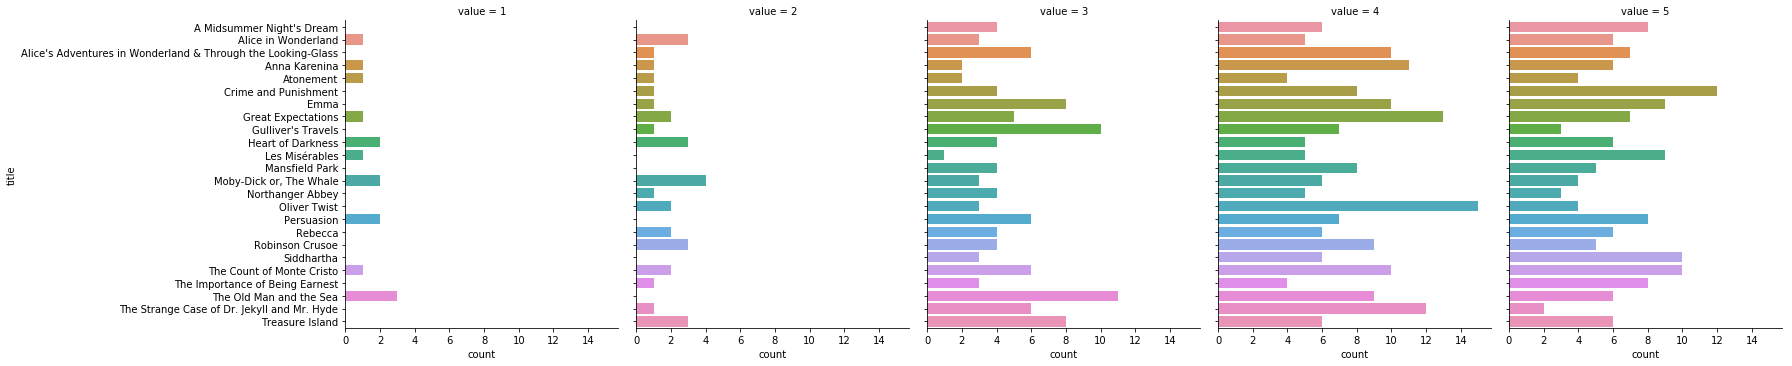

In [9]:
not_null_ratings = rating_matrix_long[rating_matrix_long['value']>0]
sns.catplot(x=None, y="title", col="value", kind="count",data=not_null_ratings); 

#### Split Training and Test Data

Our final pre-processing step requires us to split our data into training and test sets. We chose a small test size of .1 based on the small availability of user-ratings per each novel. 

In [10]:
#### Uncertain if this is necessary.... SHOULD WE BE USING rating_matrix_long HERE??
subset = subset[['user_id','title','rating']] 

# load dataset into suprise format from a pandas datafram
reader = Reader(rating_scale=(1,5)) # sets upper and lower limit of the SVD rating 
SVD_df = Dataset.load_from_df(subset,reader) 

# split data into train and test sets
train_set, test_set = train_test_split(SVD_df,test_size=.10)

In [11]:
# compare subset vs long matrix ratings. long matrix includes 0 for user/book combos without ratings. 
# delete section upon final review
print(subset.shape)
print(rating_matrix_long.shape)

(527, 3)
(2400, 3)


<h2 style="color:#088A68;">Singular Value Decomposition</h2>

In [12]:
# Train a SVD Model with 5 Latent factor 
#Latetnt feature matrix created 
svd_model = SVD(n_factors=5)
svd_model.fit(train_set)

In [13]:
svd_model.qi.shape

(25, 5)

In [14]:
svd_model.pu.shape

(100, 5)

In [15]:
svd_model.trainset

In [16]:
# In SVD every item is link to an number, by using _raw2inner_id_items 
# we can see the correspoding ID of the Item i.e. Book

type(svd_model.trainset._raw2inner_id_items)
# Dict for Item from latent feature 
idx_item_d = svd_model.trainset._raw2inner_id_items

#Dict for User from latent feature 
idx_user_d =svd_model.trainset._raw2inner_id_users

In [17]:
# dataframe of book with latent Feature ID
idx_book = pd.DataFrame(idx_item_d.items(), columns=['Book_Title', 'Book_Feature_Id'])
idx_book.head()

Book_Title  Book_Feature_Id
0  The Old Man and the Sea                0
1           Mansfield Park                1
2               Siddhartha                2
3          Robinson Crusoe                3
4     Crime and Punishment                4

In [18]:
# dataframe of User with latent Feature ID
idx_user = pd.DataFrame(idx_user_d.items(), columns=['User', 'User_Feature_Id'])
idx_user.head()

User  User_Feature_Id
0  31936                0
1  47248                1
2  38474                2
3  46884                3
4  20749                4

In [19]:
# let find the latent feature vector for 'The Count of Monte Cristo'

print (idx_item_d.get('The Count of Monte Cristo'))
idx_book[idx_book.Book_Title=="The Count of Monte Cristo"]



11


Book_Title  Book_Feature_Id
11  The Count of Monte Cristo               11

In [20]:
# Now lets find latent feature for this 'Frankenstein' which at index of 1 of feature latent matrix 


print("Each book has {} latent features.".format(svd_model.qi[1].shape[0]))
svd_model.qi[1]

Each book has 5 latent features.


array([ 0.08691041,  0.05887084, -0.07297862, -0.12725933,  0.14500362])

In [21]:
rating_matrix

title    A Christmas Carol  A Midsummer Night's Dream  Alice in Wonderland  \
user_id                                                                      
110                      0                          0                    1   
115                      0                          0                    0   
321                      0                          4                    4   
900                      0                          0                    0   
1032                     0                          3                    0   
1478                     0                          4                    0   
2955                     0                          0                    0   
3310                     0                          0                    2   
3992                     0                          0                    0   
6289                     5                          0                    0   
6292                     0                          0                    0   
6652                     0                          0                    0   
6903                     3                          0                    0   
7574                     0                          5                    0   
7729                     4                          0                    0   
8103                     0                          0                    0   
10145                    3                          0                    0   
10208                    0                          5                    5   
10733                    0                          0                    0   
12137                    0                          0                    0   
12580                    5                          0                    0   
13038                    0                          0                    3   
13280                    0                          0                    0   
13286                    0                          0                    0   
13451                    0                          0                    0   
14795                    0                          0                    0   
16033                    0                          0                    0   
16165                    0                          0                    0   
16469                    0                          0                    0   
16868                    0                          0                    0   
...                    ...                        ...                  ...   
38216                    0                          0                    0   
38474                    0                          0                    0   
39291                    0                          0                    0   
40991                    0                          0                    2   
41289                    2                          5                    0   
41761                    0                          0                    0   
42032                    0                          0                    3   
42075                    1                          0                    0   
42076                    0                          0                    0   
42164                    0                          0                    0   
42302                    0                          0                    0   
42581                    0                          3                    0   
43927                    5                          0                    5   
45294                    3                          0                    0   
46694                    0                          0                    0   
46884                    5                          0                    4   
47248                    0                          5                    0   
47672                    3                          3                    0   
47693                 

In [25]:
# checking Predicted rating Vs Actaul Rating of the Book
def get_book_rating(svdModel,MainData,tuser,tbook):
    act_Rate = MainData[( MainData['title'] == tbook ) & (subset['user_id'] == int(tuser))].rating
    return act_Rate, svdModel.predict(tuser,tbook)


In [26]:
test_user = '321'
test_book ="Alice in Wonderland"

# All_Data[( All_Data['title'] == 'Gulliver\'s Travels' ) & (All_Data['user_id'] == int(test_user))].rating

check  , result = get_book_rating(svd_model,subset,'321','Alice in Wonderland')
print('Actual Rating: {}'. format(check.values[0]))
print(result)

Actual Rating: 4
user: 321        item: Alice in Wonderland r_ui = None   est = 3.83   {'was_impossible': False}


In [27]:

check  , result = get_book_rating(svd_model,subset,'110','Treasure Island')
print('Actual Rating: {}'. format(check.values[0]))
print(result)

Actual Rating: 2
user: 110        item: Treasure Island r_ui = None   est = 3.59   {'was_impossible': False}


In [28]:
# Perfrom the test on test_set using the Model svd_model with 5 latent Feature
predictions = svd_model.test(test_set)

# check the RMSE for the test set using the SVD model
print("User-based Model : Test Set")
accuracy.rmse(predictions, verbose=True)

User-based Model : Test Set
RMSE: 0.9070


0.9070394837936328

In [29]:
avg_rmse=[]

for i in range(100):
    train_set, test_set = train_test_split(SVD_df,test_size=.90)
    predictions = svd_model.test(test_set)
    # check the RMSE for the test set using the SVD model
    # print("User-based Model : Test Set")
    avg_rmse.append(accuracy.rmse(predictions, verbose=False))

def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)


mean(avg_rmse)

0.8597909486444908

In [30]:
# Using Cosine similarty among the vector find similar Book
from scipy import spatial

idx_item_d.get('Crime and Punishment')

vector_book1 = svd_model.qi[idx_item_d.get('Atonement')]
print('Latent vector for Book {} : {}'.format('Atonement',vector_book1))
vector_book2 = svd_model.qi[idx_item_d.get('Oliver Twist')]
print('Latent vector for Book {} : {}'.format('Oliver Twist',vector_book1))

# Cosine Distance 
vector_cosine =1-spatial.distance.cosine(vector_book1,vector_book2)
print('Cosine similarlity for Latent vector for Book {} {}: {}'.format('Atonement','Oliver Twist',vector_cosine))



Latent vector for Book Atonement : [-0.05112992  0.01767866  0.02591723  0.04074128  0.12495975]
Latent vector for Book Oliver Twist : [-0.05112992  0.01767866  0.02591723  0.04074128  0.12495975]
Cosine similarlity for Latent vector for Book Atonement Oliver Twist: 0.17885012497173447


In [31]:
len(idx_book.Book_Title)


25

In [32]:
# # Here we are listing all the book and corresponding cosine similarty with all the other book
# Cosine similarity of movies latent feature vector 
# items_dic

items_dic = {}
len(svd_model.qi)
for i in range (len(idx_book.Book_Title)):
    cosine = {}
    vect1_book = [i for i in svd_model.qi[idx_item_d.get(idx_book.Book_Title[i])]]
#     items_dic[idx_book.Book_Title[i]] = vect1_book  
    for k in range (len(svd_model.qi)):
        cosine[idx_book.Book_Title[k]] = 1- spatial.distance.cosine(vect1_book,svd_model.qi[k])
#         cosine[(1- spatial.distance.cosine(vect1_book,svd_model.qi[k]))] =  idx_book.Book_Title[k]
    sorted_x = sorted(cosine.items(), key=lambda kv: kv[1],reverse=True)
    items_dic[idx_book.Book_Title[i]] = sorted_x  
    

# Method to show N item from Dict
def show_dict_item(n, dict_obj):
    return {k: dict_obj[k] for k in list(dict_obj)[:n]}

# build Final Recommendation by Book Title 
# Not Dropping the books already read by user 
def get_book_recommendation(title,number_of_rec=5):
    Rec_Order = items_dic.get(title)
    return Rec_Order[1:6]


print(show_dict_item(2,items_dic))


{'The Old Man and the Sea': [('The Old Man and the Sea', 1.0), ('The Count of Monte Cristo', 0.7230043922779235), ('Mansfield Park', 0.7050215107072871), ("Gulliver's Travels", 0.6720471470640851), ('Rebecca', 0.5157572521609678), ('Northanger Abbey', 0.49536629787900255), ('Heart of Darkness', 0.44463043090817544), ('Alice in Wonderland', 0.43508040390013747), ('Siddhartha', 0.32252444954335036), ('A Christmas Carol', 0.24516048628766862), ("Alice's Adventures in Wonderland & Through the Looking-Glass", 0.14284404163543063), ('Les Misérables', 0.13491191591003404), ('Anna Karenina', 0.10676574130212246), ('Crime and Punishment', -0.14403752622977595), ('Robinson Crusoe', -0.14848317496987562), ('Emma', -0.275363910885593), ("A Midsummer Night's Dream", -0.29017222119064723), ('Persuasion', -0.3253617870635601), ('Treasure Island', -0.34432156846484263), ('The Strange Case of Dr. Jekyll and Mr. Hyde', -0.3875580928922051), ('Atonement', -0.4608816208105777), ('Moby-Dick or, The Whale',

In [33]:
# Recommend top 5 book by Book Title 'Lord of the Flies'
get_book_recommendation('Robinson Crusoe')

[('The Strange Case of Dr. Jekyll and Mr. Hyde', 0.904537274530449),
 ('Heart of Darkness', 0.7635022504124185),
 ("Alice's Adventures in Wonderland & Through the Looking-Glass",
  0.6876361269534382),
 ("A Midsummer Night's Dream", 0.6821382650534779),
 ('Treasure Island', 0.5573129010053816)]

In [34]:
get_book_recommendation('Heart of Darkness')

[("Alice's Adventures in Wonderland & Through the Looking-Glass",
  0.7944272637580775),
 ('Robinson Crusoe', 0.7635022504124185),
 ("Gulliver's Travels", 0.7070861885207471),
 ('Mansfield Park', 0.6200958280873706),
 ('The Strange Case of Dr. Jekyll and Mr. Hyde', 0.6030087987552588)]

In [35]:
#to get the Dict from item_dic dict for movie 'Frankenstein'
Rec_Order = items_dic.get('A Midsummer Night\'s Dream')
Rec_Order

[("A Midsummer Night's Dream", 1.0),
 ('Robinson Crusoe', 0.6821382650534779),
 ('Treasure Island', 0.6274934507682739),
 ('Atonement', 0.4924076853520045),
 ('The Strange Case of Dr. Jekyll and Mr. Hyde', 0.4635621358216828),
 ('The Importance of Being Earnest', 0.460486977335561),
 ("Gulliver's Travels", 0.36461833833515156),
 ('Crime and Punishment', 0.3574447695276315),
 ('Anna Karenina', 0.310956972079812),
 ('Mansfield Park', 0.28200648575635967),
 ('Heart of Darkness', 0.21311213419398056),
 ('Emma', 0.11105366863094224),
 ("Alice's Adventures in Wonderland & Through the Looking-Glass",
  0.08640237138571716),
 ('Alice in Wonderland', 0.037096767000014186),
 ('Persuasion', -0.0598377588196386),
 ('Oliver Twist', -0.06334503522020496),
 ('Great Expectations', -0.2334004825931233),
 ('Moby-Dick or, The Whale', -0.24214704526347042),
 ('The Old Man and the Sea', -0.29017222119064723),
 ('The Count of Monte Cristo', -0.4631597499054896),
 ('Les Misérables', -0.5177553227451508),
 ('

<h2 style="color:#088A68;">Alternating Least Squares Method</h2>
In case we choose to explore ALS technique as well ^^

<h2 style="color:#088A68;">Surprise!</h2>

<h2 style="color:#088A68;">Analysis</h2>

---
#### References: 
*  **[Goodbooks-10k:](http://fastml.com/goodbooks-10k-a-new-dataset-for-book-recommendations/)** A New Dataset for Book Recommendations